# Statistically Testing 2P Responses to Stimulus
In most analyses, some form of *inclusion criteria* is used to select neurons that are "responsive" to the stimulus conditions presented. There are no universally agreed upon inclusion criteria for this type of selection. In [{cite}`Mesa2021`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114876/), it is demonstrated that the choice of inclusion criteria can dramatically affect what neurons are selected as responsive. This notebook does a similar demonstration, using the same five inclusion criteria on Ophys dF/F recordings to select responsive neurons from one experimental session. It can be seen that very different selections are made depending on the criteria used. This also underscores how different critera might be more or less appropriate for the type of stimulus and the type of measurements being used for analysis. We are sharing these so that this comparison can be reproduced on data and so results can more effectively use this choice to make their results more robust. For more information about dF/F data, see [Visualizing 2P Responses to Stimulus](../visualization/visualize_2p_responses.ipynb).

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dandi_utils import dandi_download_open
from scipy import interpolate
from scipy.stats import ttest_ind

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. In this example, we use the dF/F trace from an Ophys NWB File, so you'll have to choose one with the same kind of data. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key.

In [3]:
dandiset_id = "000036"
dandi_filepath = "sub-389014/sub-389014_ses-20180705T152908_behavior+image+ophys.nwb"
download_loc = "."
dandi_api_key = "0bb3196c6d5e115d1adb92853c748c450fb6e78c"

In [4]:
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.55.1) of dandi/dandi-cli is available. You are using 0.46.6


File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\pynwb\base.py:193: UserWarning: TimeSeries 'running_velocity': Length of data does not match length of timestamps. Your data may be transposed. Time should be on the 0th dimension
  warn("%s '%s': Length of data does not match length of timestamps. Your data may be transposed. "
c:\Users\carter.peene\AppData\Local\Prog

### Getting 2P Data and Stimulus Data
Below, the fluorescence traces and timestamps are read from the file's `Processing` section. In this notebook, we will be interested in the DFF trace specifically. Note that the exact format to access these traces can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below, as well as the names of all the tables. For more information on the dF/F data, see [Visualizing 2P Responses to Stimulus](../visualization/visualize_2p_responses.ipynb).

In [8]:
nwb.processing["ophys"]["DfOverF"]

DfOverF pynwb.ophys.DfOverF at 0x2854263653712
Fields:
  roi_response_series: {
    imaging_plane_1 <class 'pynwb.ophys.RoiResponseSeries'>
  }

In [15]:
# dff = nwb.processing["ophys"]["dff"]
# dff_trace = dff.roi_response_series["traces"].data
# dff_timestamps = dff.roi_response_series["traces"].timestamps

dff = nwb.processing["ophys"]["DfOverF"]
dff_trace = np.array(dff.roi_response_series["imaging_plane_1"].data).transpose()
dff_timestamps = dff.roi_response_series["imaging_plane_1"].timestamps[:-1]

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(127177, 41)
(127177,)


### Fluorescence Interpolation
Because we cannot be certain that the dF/F trace is at a perfectly regular Hz, we will interpolate it to be able to compare stimulus timestamps to their approximate dF/F times. After you have a valid list of timestamps, you can generate a linearly-spaced timestamp array called `time_axis`, and interpolate the dF/F data along it, making interpolated DFF data called `interp_dff`. This should be a 2D array with dimensions `roi` and `time`, where ROIs are the different cells whose fluorescence is measured. Here, the timestamps are interpolated to 10 Hertz, but you can change this by setting `interp_hz`.

In [16]:
interp_hz = 10

In [17]:
print(dff_trace.shape)
print(dff_timestamps.shape)

(127177, 41)
(127177,)


In [18]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(41, 42181)


### Selecting Stimulus Times
Different types of stimulus require different kinds of inclusion criteria. Since the available stimulus tables vary significantly depending which NWB file and which experimental session you're analyzing, you'll have to adjust some values below. First, select which stimulus table you want by changing the key used below in `nwb.intervals`. The list of stimulus table names is printed below to inform this choice. Additionally, you'll have to modify the function `stim_select` to select the stimulus times you want to use. In this example, a natural movie of worms is the selected stimulus because natural movies typically evoke strong responses. The repeated frame 40 is chosen here as our selected stimulus time, somewhat arbitrarily.

In [19]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

[]


In [ ]:
# stim_table = nwb.intervals["movie_worms_fwd_presentations"]

In [33]:
# use this if nwb intervals section has no stim information
def stim_obj_to_table(nwb):
    all_labeled_stim_timestamps = []
    for stim_type, stim_obj in nwb.stimulus.items():
        start_times = stim_obj.timestamps[:-1]
        stop_times = stim_obj.timestamps[1:]
        frames = stim_obj.data[:-1]
        l = len(start_times)
        labeled_timestamps = list(zip(start_times, stop_times, frames, [stim_type]*l))
        all_labeled_stim_timestamps += labeled_timestamps
    
    stim_table = pd.DataFrame(all_labeled_stim_timestamps, columns=("start time", "stop time", "frame", "stimulus type"))
    return stim_table

stim_table = stim_obj_to_table(nwb)

In [34]:
# print(stim_table.colnames)
stim_table[:10]

,start time,stop time,frame,stimulus type
0,355.807277,355.823973,0,conspecifics
1,355.823973,355.840751,0,conspecifics
2,355.840751,355.857337,1,conspecifics
3,355.857337,355.874002,1,conspecifics
4,355.874002,355.890685,2,conspecifics
5,355.890685,355.907353,2,conspecifics
6,355.907353,355.924055,3,conspecifics
7,355.924055,355.940699,3,conspecifics
8,355.940699,355.957404,4,conspecifics
9,355.957404,355.974125,4,conspecifics


In [64]:
set(stim_table["stimulus type"])

{'conspecifics',
 'crickets',
 'dots',
 'human_montage',
 'man_writing',
 'mouse_montage_1',
 'mouse_montage_1_spatial_phase_scramble',
 'mouse_montage_1_temporal_phase_scramble',
 'mouse_montage_2',
 'mousecam',
 'mousecam_spatial_phase_scramble',
 'noise',
 'snake',
 'spontaneous'}

In [95]:
### select start times from table that fit certain critera here

# stim_select = lambda row: True
# stim_select = lambda row: float(row.frame) == 40
# all_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]

all_stim_times = []
for i in range(len(stim_table)):
    if i == 0:
        continue
    if stim_table["stimulus type"][i] == "mousecam" and stim_table["frame"][i] == 10 and stim_table["frame"][i-1] != 10:
        all_stim_times.append(stim_table["start time"][i])

len(all_stim_times)

10

### Aligning Stimulus Response Time Windows
Now that you have your interpolated dF/F data and the selected stimulus timestamps, you identify the windows of time in the dF/F data that exist around each stimulus event. Since the dF/F data have been interpolated, we can easily translate timestamps to indices within the LFP trace array. Set `window_start_time` to be a negative number, representing the seconds before the stimulus event and `window_end_time` to be number of seconds afterward. Then the `windows` array will be generated as a set of slices of the `interp_dff` trace by using `interp_hz` to convert seconds to array indices. The output of this, the `windows` array, should be a 3D array shape `trials` by `rois` by `time`. These windows can be used for our analysis, and can be used to apply and display the affects of our various inclusion criteria.

In [67]:
window_start_time = -2
window_end_time = 3

In [68]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in all_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to dF/F percentage
print(windows.shape)

(10, 41, 50)


### Defining Plotting Methods
Here are a few methods to display the stimulus response windows. These will be used to display the ROIs selected by each inclusion critera. `show_dff_response` can be used to show one stimulus response window (or an average window). `show_many_responses` will be used to show many windows alongside eachother. You can use the resulting plots to compare how different inclusion criteria can affect what rois are selected as *responsive* neurons.

In [69]:
def show_dff_response(ax, dff, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return

    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    if cbar:
        fig.colorbar(img, shrink=0.5, label=cbar_label)

    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [70]:
def show_many_responses(windows, rows, cols, window_idxs=None, title=None, subplot_title="", xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=100):
    if window_idxs is None:
        window_idxs = range(len(windows))
    windows = windows[window_idxs]
    
    # handle case with no input data
    if len(windows) == 0:
        print("Input data has length 0; Nothing to display")
        return
    # handle cases when there aren't enough windows for number of rows
    if len(windows) < rows*cols:
        rows = (len(windows) // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols+2, 2*rows+2), layout="constrained")
    # handle case when there's only one row
    if len(axes.shape) == 1:
        axes = axes.reshape((1, axes.shape[0]))
    
    for i in range(rows*cols):
        ax_row = int(i // cols)
        ax_col = i % cols
        ax = axes[ax_row][ax_col]
        
        if i > len(windows)-1:
            ax.set_visible(False)
            continue

        window = windows[i]
        show_dff_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {window_idxs[i]}")
        if ax_row != rows-1:
            ax.get_xaxis().set_visible(False)
        if ax_col != 0:
            ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=axes, shrink=1.5/rows, label=cbar_label)


### Viewing Stimulus Response Windows
At last we are ready to play with the data. For starters, the stimulus windows can averaged across all stimulus trials to get an average view of how the ROIs respond.

(41, 50)


Text(0, 0.5, 'ROI (neuron)')

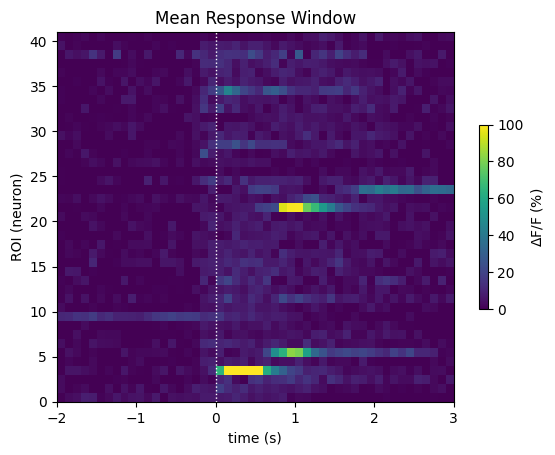

In [71]:
mean_window = np.mean(windows, axis=0)
print(mean_window.shape)
fig, ax = plt.subplots()
show_dff_response(ax, mean_window, window_start_time, window_end_time, vmin=0, vmax=100, cbar_label="$\Delta$F/F (%)")
ax.set_title("Mean Response Window")
ax.set_xlabel("time (s)")
ax.set_ylabel("ROI (neuron)")

### Showing Response Windows
This is a view of many of the raw data response windows. Here, we show just the first 24 response windows. It can be seen that some neurons definitely show activity over time. However, it can be difficult to identify any patterns between trials with this view. Below, we also generate a *neuronwise* view of the first 24 neuron's response windows. That is, a view of how each neuron responses across all trials. From this, we can see more clearly how neurons behave. Immediately, you can tell that some neurons have an evoked response at the onset of the stimulus, while others appear to be inhibited by the stimulus, and yet others show no strong responses.

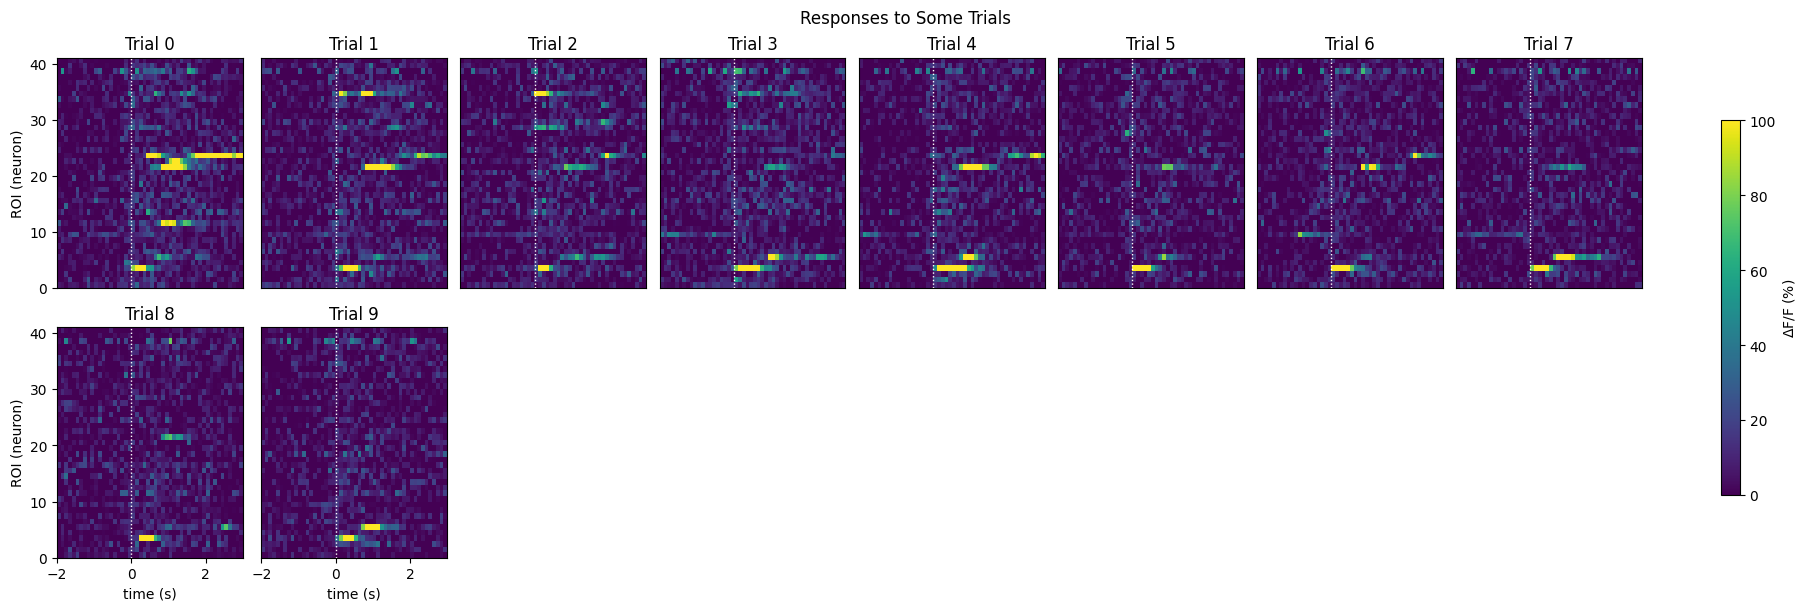

In [72]:
show_many_responses(windows,
                    3,
                    8,
                    title="Responses to Some Trials",
                    subplot_title="Trial",
                    xlabel="time (s)",
                    ylabel="ROI (neuron)",
                    cbar_label="$\Delta$F/F (%)")

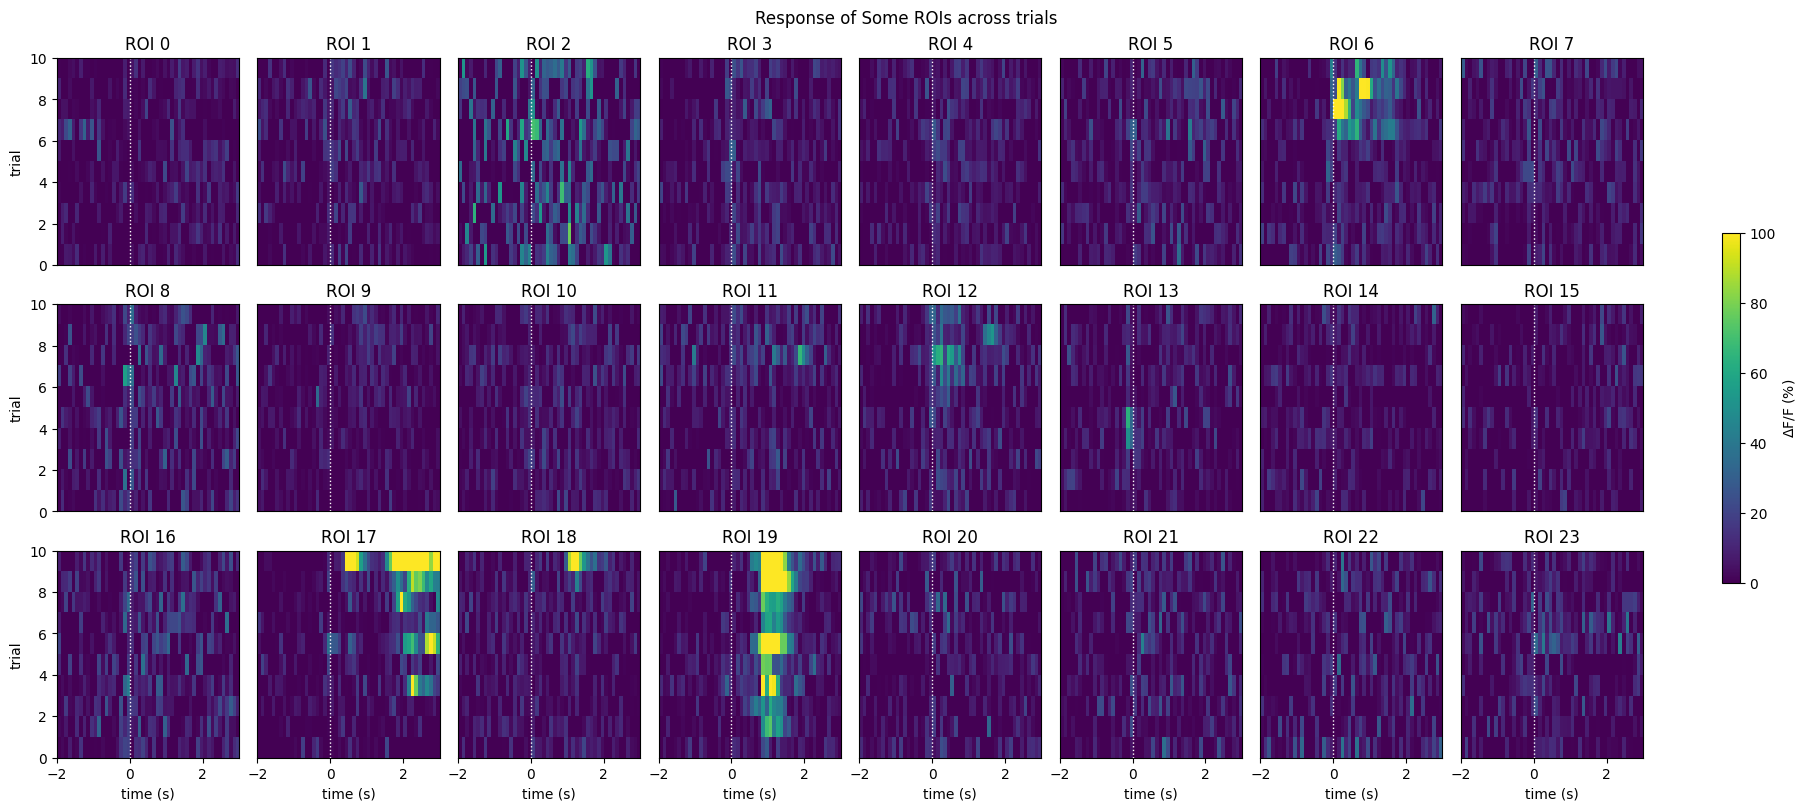

In [73]:
neuronwise_windows = np.swapaxes(windows,0,1)
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    title="Response of Some ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

### Inclusion Criteria
Now we can apply various inclusion critera to see how they affect what neurons are selected. 5 inclusion criteria are demonstrated below, but it should be noted that there are many other ways to select neurons, or to adjust the ones shown here. Different inclusion criteria have different levels of permissiveness, and will result in different behaviors in the selected cells. To start, we split the windows, in time, at the onset of the stimulus to yield the `baseline` activity of each roi, and the `evoked_response` activity. These should have shape `trial` by `roi` by `time`. 

In [74]:
# get the index within the window that stimulus occurs (time 0)
stimulus_onset_idx = int(-window_start_time * interp_hz)
baseline = windows[:,:,0:stimulus_onset_idx]
evoked_responses = windows[:,:,stimulus_onset_idx:]

print(stimulus_onset_idx)
print(baseline.shape)
print(evoked_responses.shape)

20
(10, 41, 20)
(10, 41, 30)


#### Inclusion Criterion 1
The first criterion is one of the simplest. This one is easy to alter and has a medium level of permissiveness. Below is shown a distribution of the ROI's maximum mean evoked response. That is, the maximum dF/F value achieved during the evoked averaged response of an ROI to all stimulus trials. A line is drawn to show where the selection is made within the distribution. Also below are the neuronwise response windows of some of the selected neurons. It can be seen that these neurons appear more responsive than the (pseudo) random sample shown above.

*The maximum value of the mean evoked response is >10%* [{cite}`Sun2016`](https://rdcu.be/dbFb9)

In [75]:
mean_evoked_responses = np.mean(evoked_responses, axis=0)
max_mean_evoked_responses = np.max(mean_evoked_responses, axis=1)
IC1_selected_rois = np.where(max_mean_evoked_responses > 10)[0]
print(f"Selected ROIs {IC1_selected_rois}")

Selected ROIs [ 2  3  4  5  6  7  8 11 12 16 17 18 19 22 24 25 26 27 28 29 31 34 35 37
 38 39 40]


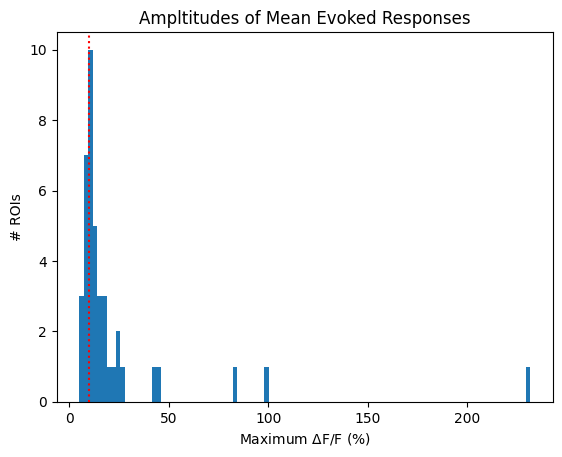

In [76]:
plt.hist(max_mean_evoked_responses, bins=100)
plt.ylabel("# ROIs")
plt.axvline(x=10, color="red", linestyle=":")
plt.xlabel("Maximum $\Delta$F/F (%)")
plt.title("Ampltitudes of Mean Evoked Responses")
plt.show()

27 / 41 ROIs selected


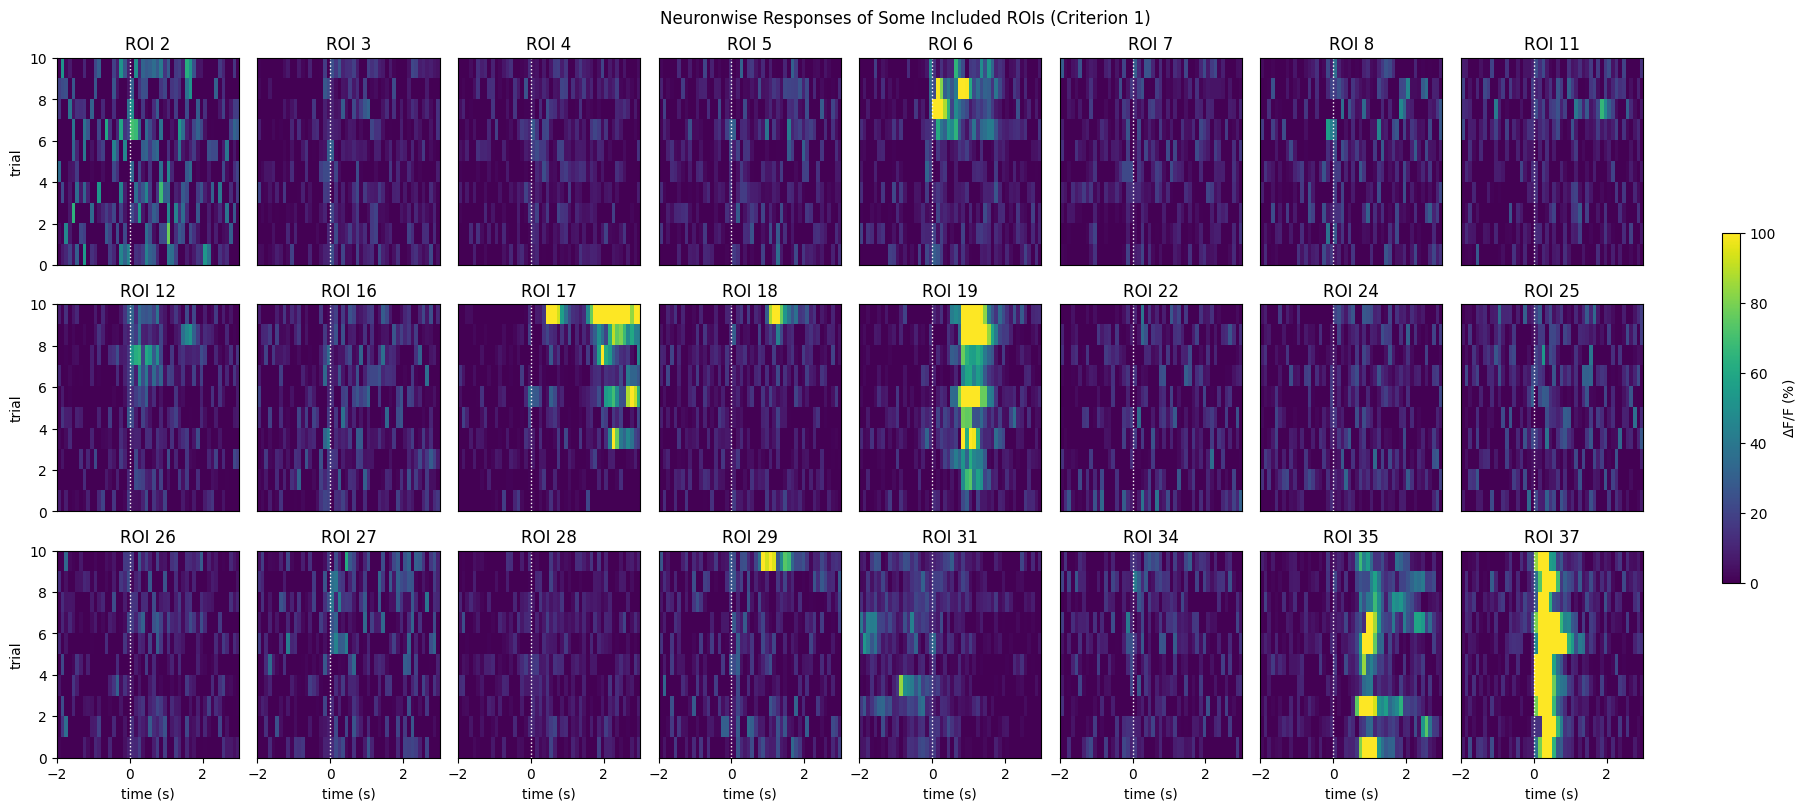

In [77]:
print(f"{len(IC1_selected_rois)} / {neuronwise_windows.shape[0]} ROIs selected")
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    window_idxs = IC1_selected_rois,
                    title="Neuronwise Responses of Some Included ROIs (Criterion 1)",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

#### Inclusion Criterion 2
This criterion is slightly more complicated, and accounts for the fact that neurons might behave inconsistently. It uses the maximum values of the evoked response, and compares it to an absolue value (5%) as well as a value relative to its own baseline activity (3x the standard deviation). It is difficult to show the exact metric being used as a distribution, but to assist in interpretation, a distribution is shown below of the the mean ratio between the maximum evoked value and the standard distribution of the baseline behavior. Note that, this is not the exact metric used to select rois; as this criterion selects rois that exhibit significant activity in 50% or more trials. For our dataset, this criterion is rather stringent, only including 4 rois in the final selection.

*In 50% of trials, the evoked response is A) larger than 3x the SD of the baseline, and B) larger than 5% dF/F* [{cite}`Roth2012`](https://www.jneurosci.org/content/jneuro/32/28/9716.full.pdf)

In [78]:
all_baseline_sds = np.std(baseline, axis=2)

max_responses = np.max(evoked_responses, axis=2)

# rois in each trial that respond more than 3x the SD of baseline
deviant_responses = max_responses > 3*all_baseline_sds
# rois in each trial that response more than 5% dff
large_responses = max_responses > 5
# rois in each trial that do both of the above
sig_responses = deviant_responses & large_responses

# rois that have significant responses in 50% or more trials
half_trials = sig_responses.shape[0] / 2
IC2_selected_rois = np.where( np.sum(sig_responses, axis=0) > half_trials )[0]
print(f"Selected ROIs {IC2_selected_rois}")

Selected ROIs [ 3  5 12 17 19 22 24 35 37 38 39]


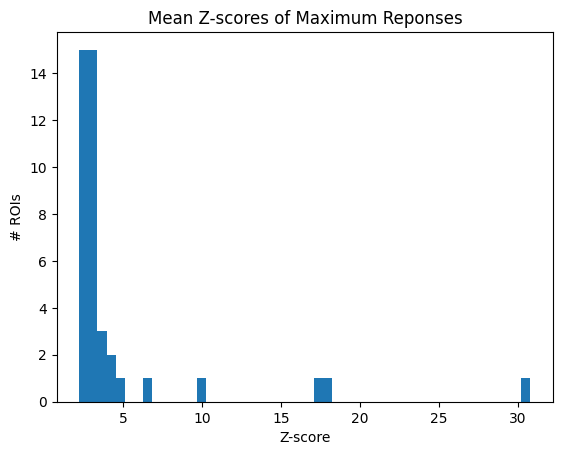

In [79]:
z_scores = np.mean(max_responses / all_baseline_sds, axis=0)
plt.hist(z_scores, bins=50)
plt.xlabel("Z-score")
plt.ylabel("# ROIs")
# plt.axvline(x=3, color="red", linestyle=":")
plt.title("Mean Z-scores of Maximum Reponses")
plt.show()

11 / 41 ROIs selected


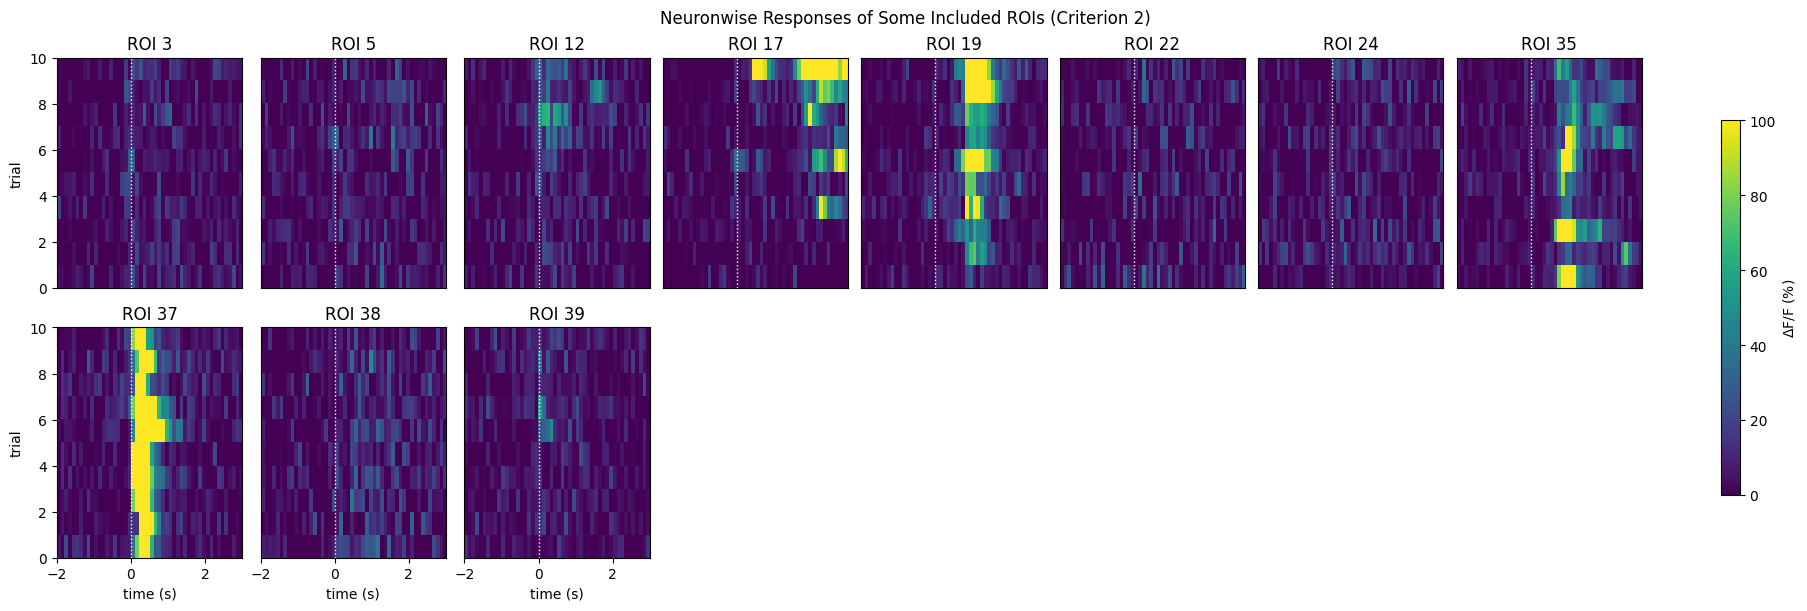

In [80]:
print(f"{len(IC2_selected_rois)} / {neuronwise_windows.shape[0]} ROIs selected")
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    window_idxs=IC2_selected_rois,
                    title="Neuronwise Responses of Some Included ROIs (Criterion 2)",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

#### Inclusion Criterion 3
This is perhaps the most sophisticated criterion in our list. For each ROI, It compares the distribution of responses between the baseline activity and the evoked activity to identify any statistically significant response. Below, an example is shown of these distributions for one ROI. Change `roi` below to view the comparison for other cells. Additionally, the distribution of p-values of all rois is shown.

*Paired T-test (p < 0.05) with Bonferroni correction, comparing the mean baseline to the mean evoked response* [{cite}`Andermann2011`](https://pubmed.ncbi.nlm.nih.gov/22196337/)

In [81]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
mean_trial_baselines = np.mean(baseline, axis=2)

n = mean_trial_responses.shape[0]
t,p = ttest_ind(mean_trial_responses, mean_trial_baselines)
IC3_selected_rois = np.where(p < 0.05 / n)[0]
print(f"Selected ROIs {IC3_selected_rois}")

Selected ROIs [ 3  4  5  8 12 15 16 19 21 26 27 28 30 31 33 35 37 38]


<function matplotlib.pyplot.show(close=None, block=None)>

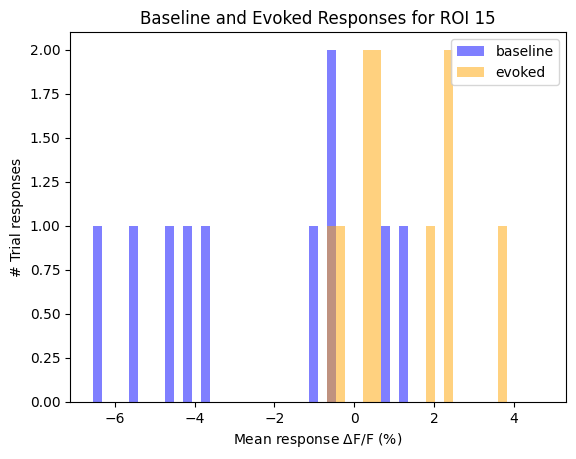

In [82]:
roi = 15
baseline_dist = mean_trial_baselines[:,roi]
response_dist = mean_trial_responses[:,roi]
max_val = max(np.maximum(baseline_dist, response_dist)) + 1
min_val = min(np.minimum(baseline_dist, response_dist))

plt.hist(baseline_dist, bins=50, range=(min_val, max_val), alpha=0.5, color="blue", label="baseline")
plt.hist(response_dist, bins=50, range=(min_val, max_val), alpha=0.5, color="orange", label="evoked")
plt.legend(loc='upper right')
plt.xlabel("Mean response $\Delta$F/F (%)")
plt.ylabel("# Trial responses")
plt.title(f"Baseline and Evoked Responses for ROI {roi}")
plt.show

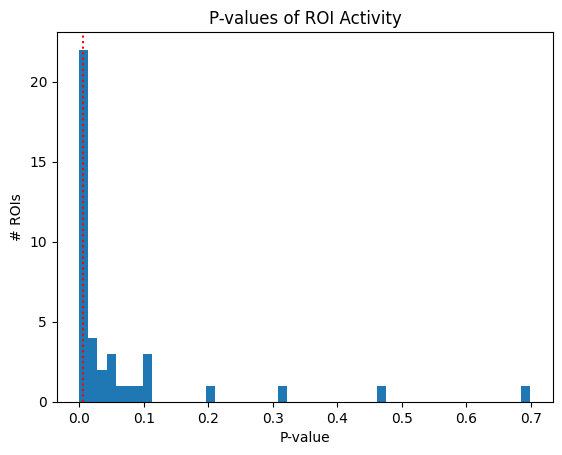

In [83]:
hist, _, _  = plt.hist(p, bins=50)
plt.xlabel("P-value")
plt.ylabel("# ROIs")
thresh = 0.05/n
plt.axvline(x=thresh, color="red", linestyle=":")
plt.title("P-values of ROI Activity")
plt.show()

18 / 41 ROIs selected


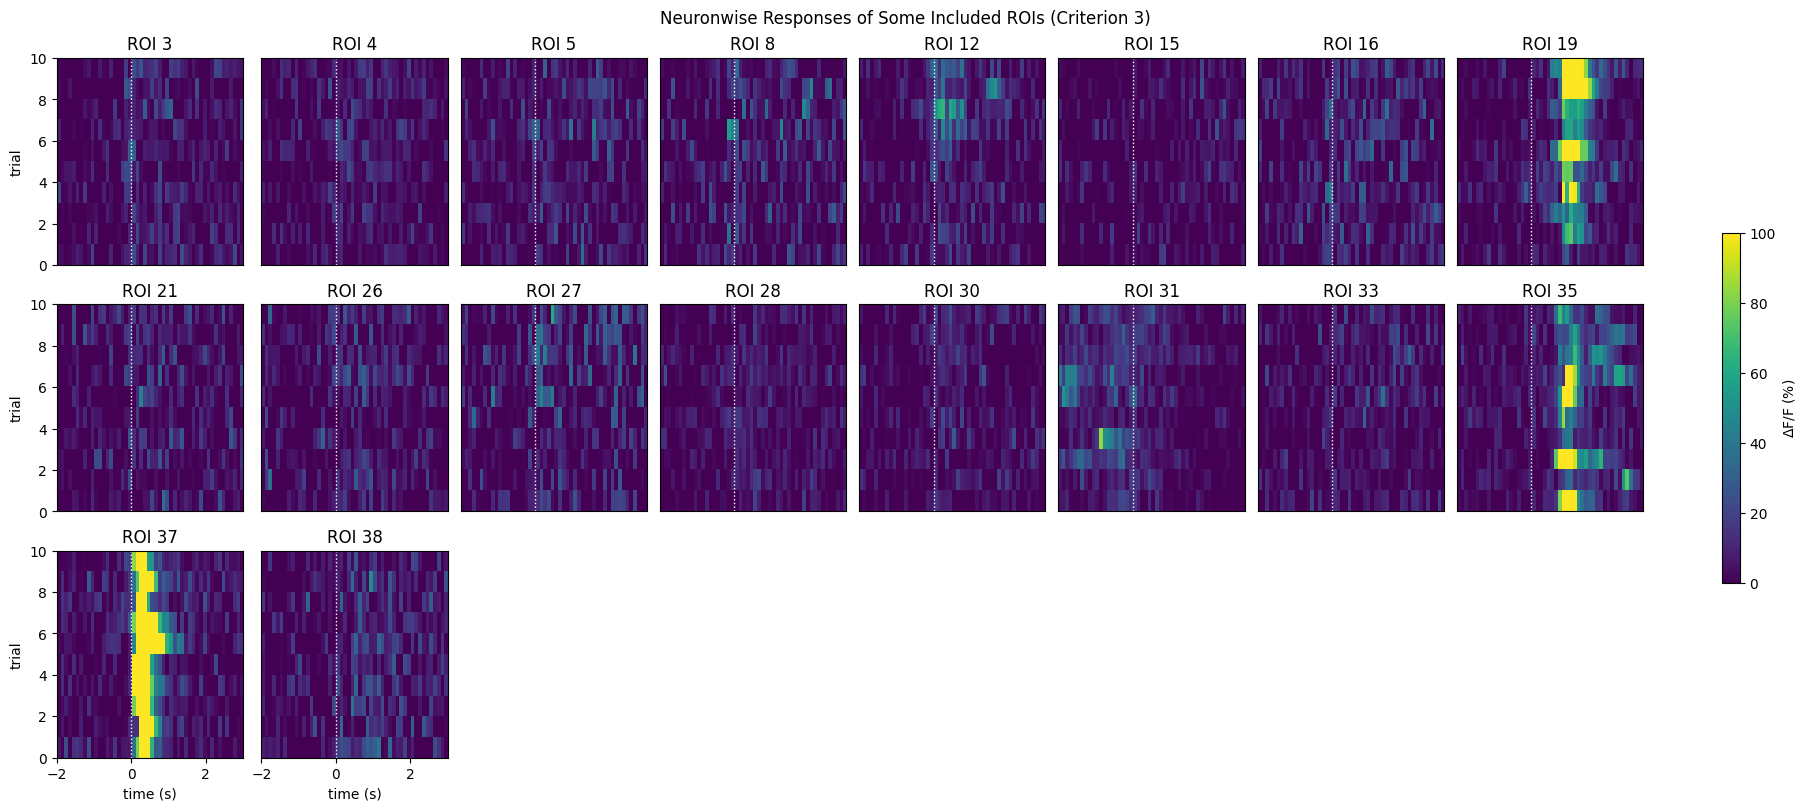

In [84]:
print(f"{len(IC3_selected_rois)} / {neuronwise_windows.shape[0]} ROIs selected")
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    window_idxs=IC3_selected_rois,
                    title="Neuronwise Responses of Some Included ROIs (Criterion 3)",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

#### Inclusion Criterion 4
This criterion is the most stringent for our dataset. It relies on calculating the measure of `reliability` of a cell's activity. It can be seen that in this example, no ROIs are selected. This is probably due to no ROIs having reliable responses to the stimulus. Perhaps conducting more trials could improve the reliability.

*A) The mean response to any stimulus condition is is > 6% dF/F and B) reliability > 1* [{cite}`Marshel2012`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3248795/).

In [85]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
response_means = np.mean(mean_trial_responses, axis=0)
response_sds = np.std(mean_trial_responses, axis=0)

mean_trial_baselines = np.mean(baseline, axis=2)
baseline_means = np.mean(mean_trial_baselines, axis=0)
baseline_sds = np.std(mean_trial_baselines, axis=0)

reliabilities = (response_means - baseline_means) / (response_sds + baseline_sds)

sig_reliabilities = reliabilities > 1
large_responses = response_means > 6
IC4_selected_rois = np.where(sig_reliabilities & large_responses)[0]
print(f"Selected ROIs {IC4_selected_rois}")

Selected ROIs [19 35 37 38]


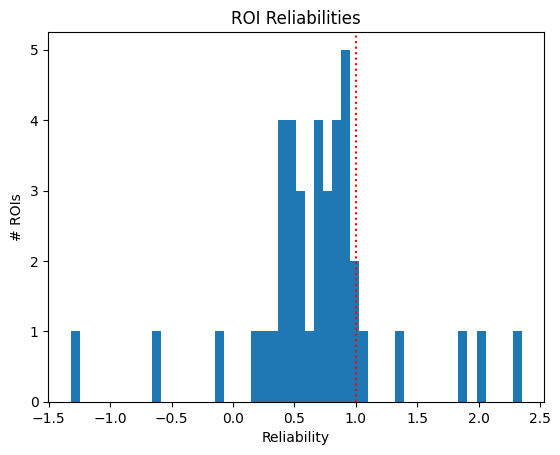

In [86]:
plt.hist(reliabilities, bins=50)
plt.ylabel("# ROIs")
plt.xlabel("Reliability")
plt.axvline(x=1, color="red", linestyle=":")
plt.title("ROI Reliabilities")
plt.show()

4 / 41 ROIs selected


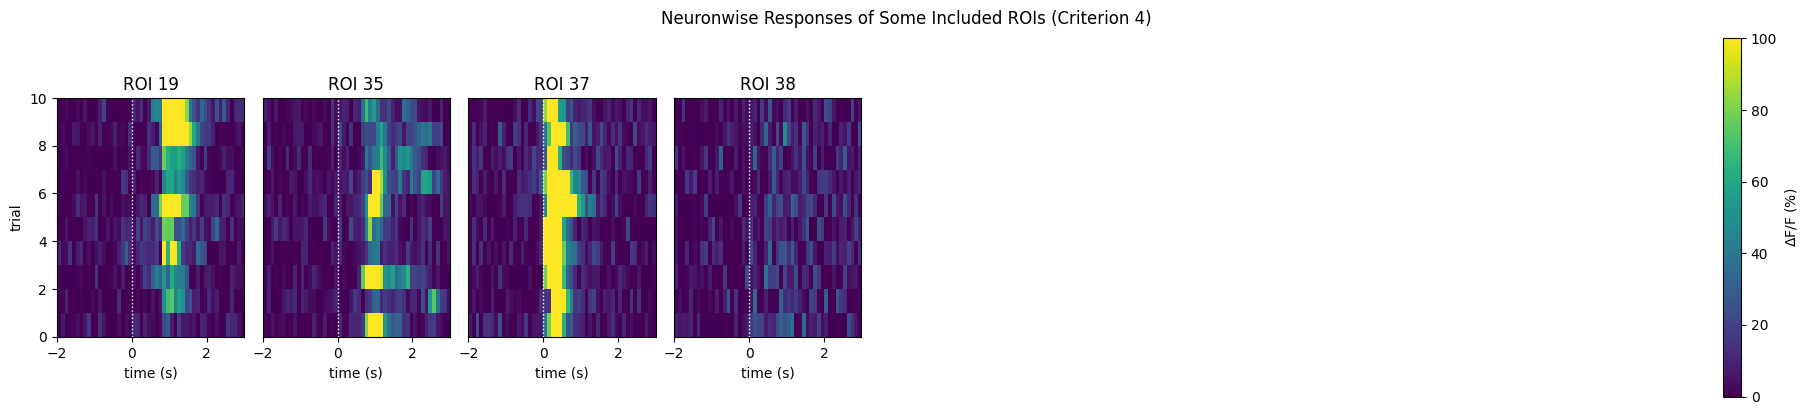

In [87]:
print(f"{len(IC4_selected_rois)} / {neuronwise_windows.shape[0]} ROIs selected")
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    window_idxs=IC4_selected_rois,
                    title="Neuronwise Responses of Some Included ROIs (Criterion 4)",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

#### Inclusion Criterion 5
Finally, the simplest criterion. This criterion is clearly the most permissive, as it includes all ROIs for this dataset.

*The maximum evoked response to any stimulus condition is > 4% dF/F* [{cite}`Tohmi2014`](https://pubmed.ncbi.nlm.nih.gov/24583013/).

In [88]:
max_responses = np.max(evoked_responses, axis=(0,2))
IC5_selected_rois = np.where(max_responses > 4)[0]
print(f"Selected ROIs {IC5_selected_rois}")

Selected ROIs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


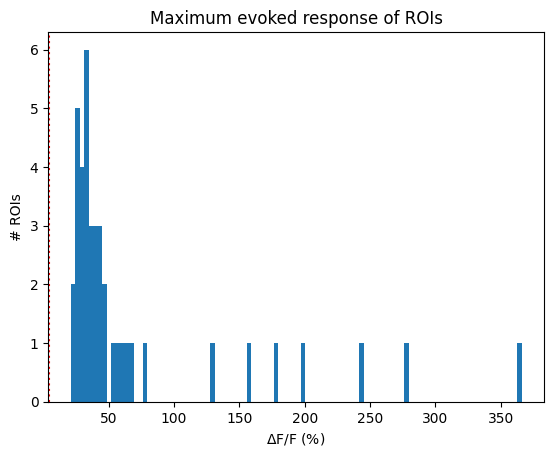

In [89]:
plt.hist(max_responses, bins=100)
plt.ylabel("# ROIs")
plt.xlabel("$\Delta$F/F (%)")
plt.axvline(x=4, color="red", linestyle=":")
plt.title("Maximum evoked response of ROIs")
plt.show()

41 / 41 ROIs selected


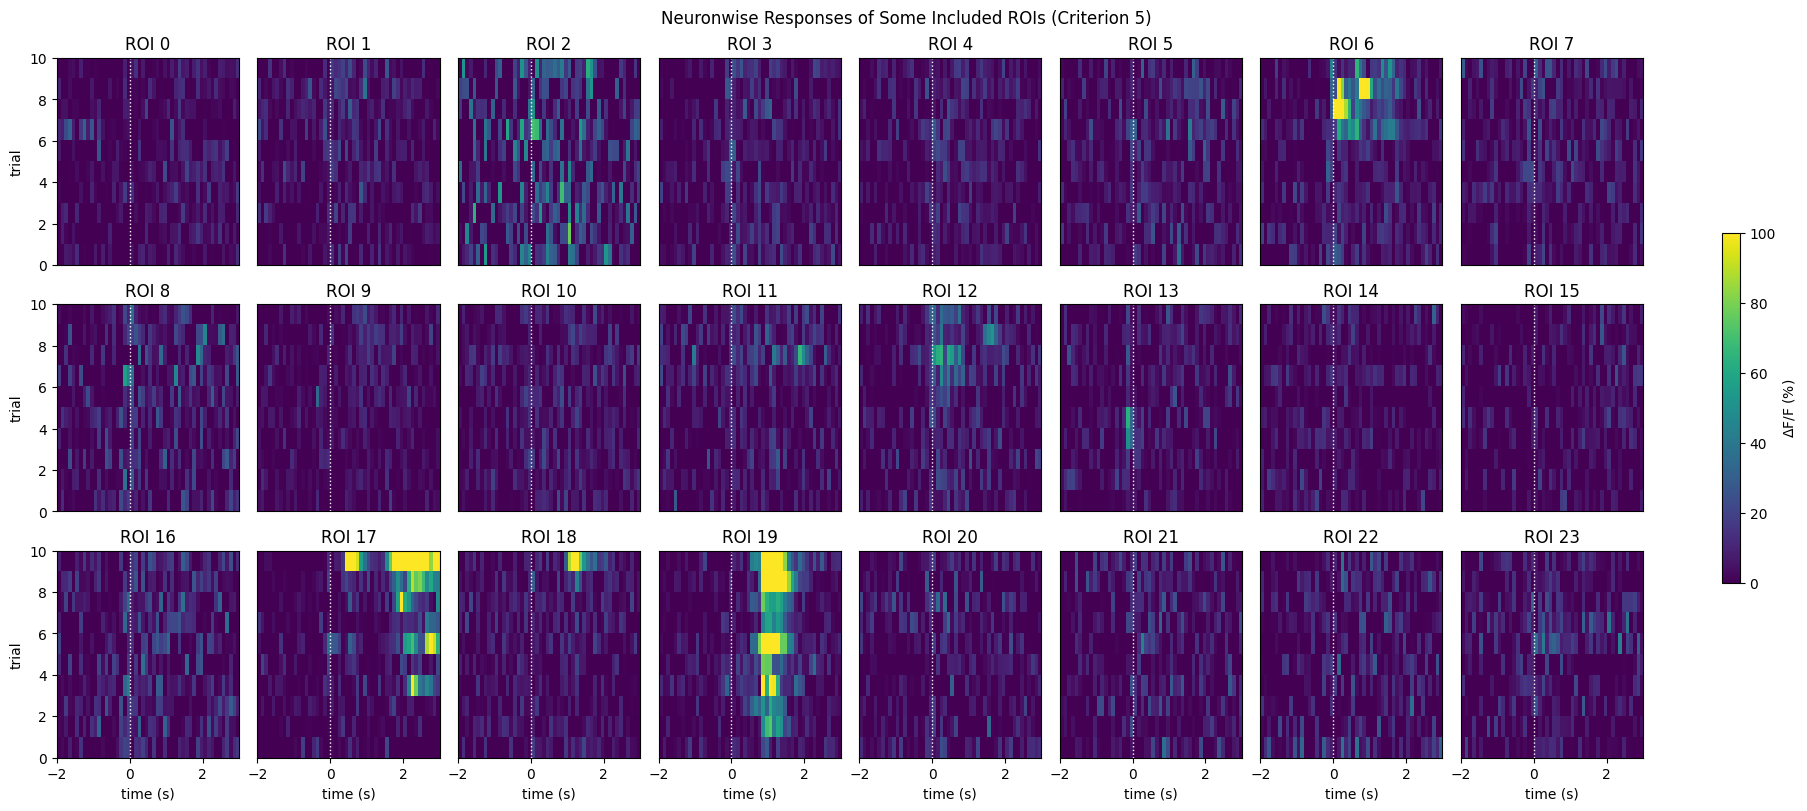

In [90]:
print(f"{len(IC5_selected_rois)} / {neuronwise_windows.shape[0]} ROIs selected")
show_many_responses(neuronwise_windows,
                    3,
                    8,
                    window_idxs=IC5_selected_rois,
                    title="Neuronwise Responses of Some Included ROIs (Criterion 5)",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")